# Relazione per il progetto di Algoritmi e Strutture Dati
L'obiettivo di questo progetto è lo sviluppo e l'analisi di algoritmi per la pianificazione di percorsi in una griglia bidimensionale con ostacoli e agenti multipli. Il problema, formalizzato come PF4EA (Pathfinding For an Entry Agent), consiste nel trovare un percorso ottimale per un nuovo agente, tenendo conto dei percorsi preesistenti di altri agenti e rispettando specifici vincoli di movimento e collisione. \
Nello specifico, il lavoro svolto ha riguardato il Compito 1, che ha richiesto la generazione di istanze del problema PF4EA, includendo la creazione delle liste di adiacenza che rappresentano il grafo della griglia, e il Compito 2, che si è focalizzato sull'implementazione dell'algoritmo ReachGoal, proposto per la risoluzione di PF4EA, con particolare attenzione alla definizione di strutture dati appropriate per limitare l'occupazione di memoria. Entrambi i compiti sono fondamentali per la successiva fase sperimentale, che valuterà le prestazioni degli algoritmi sviluppati in diverse configurazioni.

## Generazione delle griglie
La generazione delle liste di adiacenza segue un processo strutturato in diverse fasi. Innanzitutto, vengono generati *n* nodi, dove *n* è dato dal prodotto tra il numero di righe e colonne della griglia, e ciascun nodo è identificato dal proprio indice. Successivamente, si costruisce un array di lunghezza *n*, in cui ogni elemento è una lista vuota che rappresenta la lista di adiacenza del rispettivo nodo. Per popolare queste liste, si procede iterando su ogni nodo di indice *i* e si calcolano le sue coordinate *x* e *y*. Se il nodo non si trova nell'ultima colonna (`y < n_col−1`), viene aggiunto il nodo "Est" (indice `i_e=i+1`) alla lista di adiacenza del nodo corrente e viceversa. Se, inoltre, il nodo non è in alto a destra (`y < n_col−1` e `x > 0`), viene aggiunto il nodo "Nord-Est" (indice `i_ne=i+1−n_col`) alla lista di adiacenza del nodo *i* e viceversa. Analogamente, se il nodo non è in basso a destra (`y < n_col−1` e `x < n_row−1`), viene aggiunto il nodo "Sud-Est" (indice `i_se=i+n_col+1`) e alla lista del nodo "Sud-Est" viene aggiunto *i*. Infine, se il nodo non fa parte dell'ultima riga (`x < n_row−1`), viene aggiunto il nodo "Sud" (indice `i_s=i+n_col`) e reciprocamente. Questo approccio assicura che ogni nodo sia correttamente connesso ai suoi vicini secondo la topologia definita. \
Il calcolo e la generazione degli agglomerati seguono i seguenti passi:

1. **Calcolo del numero di agglomerati**: il numero totale di agglomerati viene determinato utilizzando la formula:  
   `n_agglomerati = (n_nodi * % ostacoli) / dimensione_agglomerati`.

2. **Creazione degli agglomerati**: si esegue un ciclo `for` con *i* che varia da 1 al numero totale di agglomerati. Per ciascuna iterazione:  
   - Si estrae un nodo dalla lista dei nodi disponibili. Questo nodo deve avere una lista di adiacenza di lunghezza maggiore di 0 e non deve avere vicini marcati come ostacoli. Il nodo estratto viene usato come punto di partenza per l'agglomerato.  
   - Si seleziona un nodo vicino con lista di adiacenza di lunghezza maggiore di 0 e distanza <= 1. Questo nodo viene aggiunto all'agglomerato. Il processo continua finché l'agglomerato non raggiunge le dimensioni desiderate.  
   - I nodi che appartengono all'agglomerato, insieme ai nodi vicini con distanza <= 1, vengono rimossi dalla lista dei nodi disponibili. In questo modo, si garantisce che il grafo rimanente rimanga sempre connesso.

### Parametri
Per la creazione delle vengono utilizzati i seguenti parametri:
- **numero di righe**, (min: 10, max: 50, passo:10)
- **numero di colonne**, (min: 10, max: 50, passo:10) 
- **percentuale ostacoli**, (min: 10, max: 40, passo:10)
- **dimensione agglomerati**, (min: 1, max: 4, passo:1)

### Caricamento dati


In [145]:
%matplotlib inline
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

In [146]:
df_gg_load = pd.read_csv("./data/gg_result.csv", sep=";")
df_gg_load.head()

,row,col,aggl_ratio,aggl_size,time_list(ms),time_obs(ms)
0,10,10,0.1,1,0.141268,0.125675
1,10,10,0.1,2,0.115546,0.116513
2,10,10,0.1,3,0.189003,0.244220
3,10,10,0.1,4,0.183322,0.324831
4,10,10,0.2,1,0.191187,0.413764


In [147]:
df_gg = df_gg_load.rename(columns={"time_list(ms)":"time_list", "time_obs(ms)":"time_obs"})
df_gg["size"] = df_gg["row"] * df_gg["col"]
df_gg["n_obs"] = df_gg["size"]*df_gg["aggl_ratio"]
df_gg["n_aggl"] = df_gg["n_obs"]//df_gg["aggl_size"]
df_gg["time_per_node"] = df_gg["time_list"]/df_gg["size"]
df_gg["time_per_obs"] = df_gg["time_obs"]/df_gg["n_obs"]
df_gg["time_per_aggl"] = df_gg["time_obs"]/df_gg["n_aggl"]
df_gg.head()

,row,col,aggl_ratio,aggl_size,time_list,time_obs,size,n_obs,n_aggl,time_per_node,time_per_obs,time_per_aggl
0,10,10,0.1,1,0.141268,0.125675,100,10.0,10.0,0.001413,0.012568,0.012568
1,10,10,0.1,2,0.115546,0.116513,100,10.0,5.0,0.001155,0.011651,0.023303
2,10,10,0.1,3,0.189003,0.244220,100,10.0,3.0,0.001890,0.024422,0.081407
3,10,10,0.1,4,0.183322,0.324831,100,10.0,2.0,0.001833,0.032483,0.162416
4,10,10,0.2,1,0.191187,0.413764,100,20.0,20.0,0.001912,0.020688,0.020688


### Analisi del tempo di generazione delle liste di adiacenza
L'algoritmo per la generazione presenta una complessità temporale O(n), come evidenziato dal grafico a dispersione. Il boxplot mostra la presenza di alcuni outlier superiori, che però risultano relativamente rari. Inoltre, si osserva una crescita abbastanza regolare dei valori mediani, coerente con l'andamento previsto dalla complessità temporale dichiarata.

Text(0, 0.5, 'Tempo (ms)')

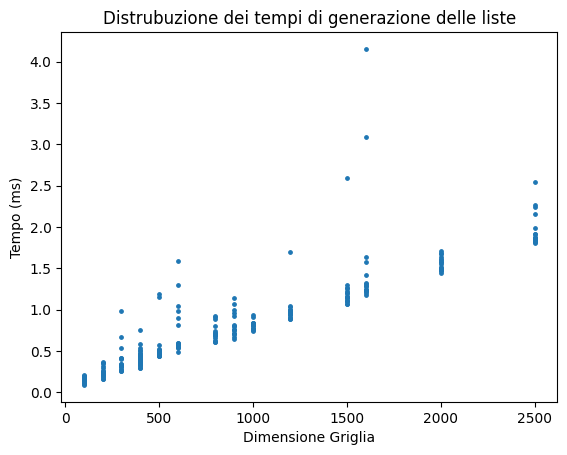

In [148]:
plt.scatter(df_gg["size"], df_gg["time_list"],s=6)
plt.title("Distrubuzione dei tempi di generazione delle liste")
plt.xlabel("Dimensione Griglia")
plt.ylabel("Tempo (ms)")

Text(0, 0.5, 'Tempo (ms)')

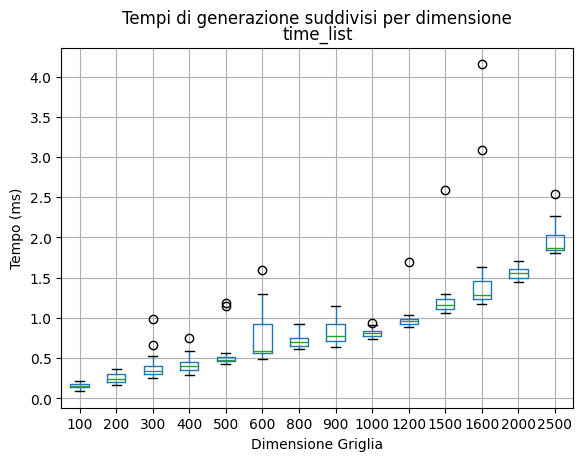

In [149]:
df_gg[["size", "time_list"]].boxplot(by="size")
plt.suptitle("Tempi di generazione suddivisi per dimensione")
plt.xlabel("Dimensione Griglia")
plt.ylabel("Tempo (ms)")

Il boxplot seguente analizza il rapporto tra il tempo di generazione delle liste di adiacenza e la dimensione della griglia. Si osserva che, per le griglie più piccole, i tempi di generazione sono mediamente più elevati e presentano una varianza maggiore rispetto a quelli delle griglie più grandi. Questo comportamento può essere attribuito alla minore quantità di dati disponibili per le griglie di dimensioni ridotte, rendendole più sensibili alle fluttuazioni.

Text(0, 0.5, 'Tempo/Dimensione Griglia')

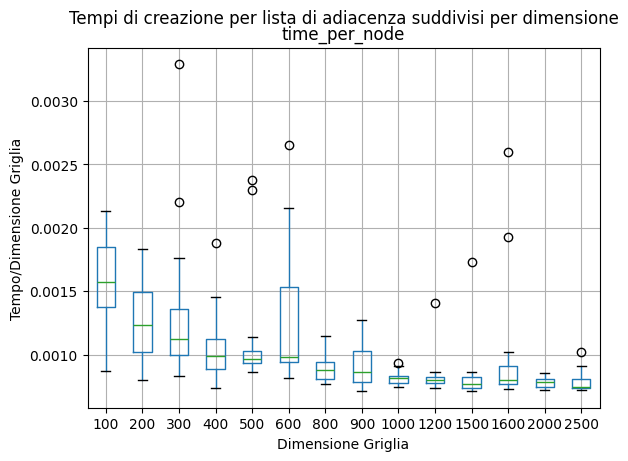

In [150]:
df_gg[["size", "time_per_node"]].boxplot(by="size")
plt.suptitle("Tempi di creazione per lista di adiacenza suddivisi per dimensione")
plt.xlabel("Dimensione Griglia")
plt.ylabel("Tempo/Dimensione Griglia")

### Tempo inserimento ostacoli
Dal grafico a dispersione si può notare un andamento esponenziale, ma è difficile fare un'analisi più accurata con pochi dati

Text(0, 0.5, 'Tempo (ms)')

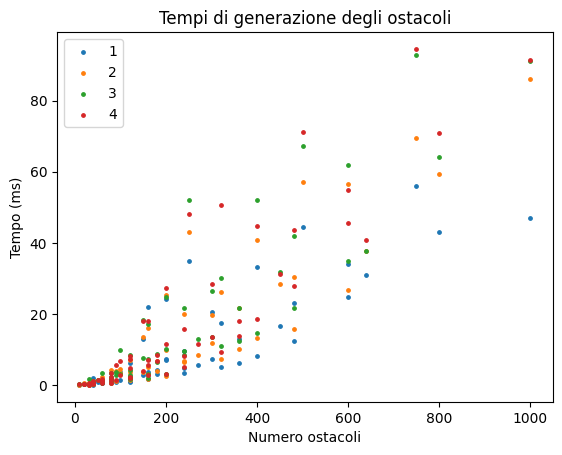

In [151]:
for i in range(1,5):
    df_loop = df_gg[df_gg ["aggl_size"]== i]
    plt.scatter(df_loop["n_obs"], df_loop["time_obs"], s=6, label=i)
plt.legend()
plt.title("Tempi di generazione degli ostacoli")
plt.xlabel("Numero ostacoli")
plt.ylabel("Tempo (ms)")

Il boxplot seguente illustra i tempi di inserimento di un singolo ostacolo, suddivisi per dimensione. Si può osservare una tendenza alla crescita delle mediane, sebbene per ottenere un'analisi più accurata sarebbe necessario aumentare la dimensione degli agglomerati.

Text(0, 0.5, 'Tempo di generazione (ms)')

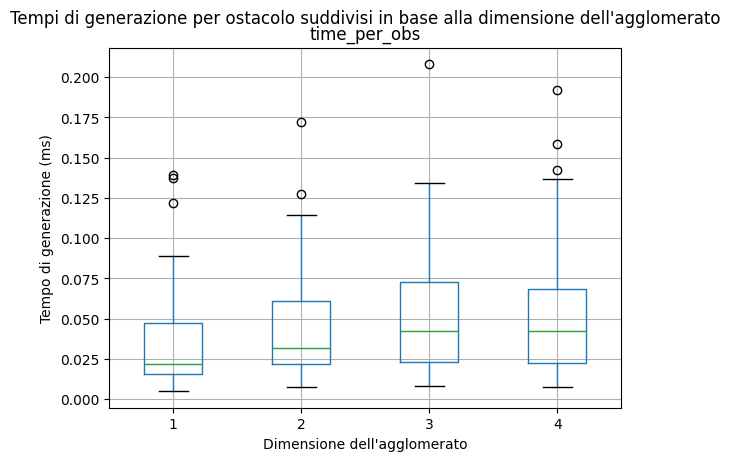

In [152]:
df_gg[["aggl_size", "time_per_obs"]].boxplot(by="aggl_size")
plt.suptitle("Tempi di generazione per ostacolo suddivisi in base alla dimensione dell'agglomerato")
plt.xlabel("Dimensione dell'agglomerato")
plt.ylabel("Tempo di generazione (ms)")

Nel seguente grafico si analizza, utilizzando un boxplot, il tempo di inserimento dei vari agglomerati suddivisi in base alla dimensione. Come c'era d'aspettarsi si nota una crescita dei tempi all'aumentare della dimensione dell'agglomerato, in oltre si nota un aumento anche un aumento della varianza. Quest'ultima osservazione può essere spiegata dal fatto che sono stati inseriti meno agglomerati di dimensione 3 o 4 rispetto a quelli di dimensione 1.

Text(0, 0.5, 'Tempo di creazione (ms)')

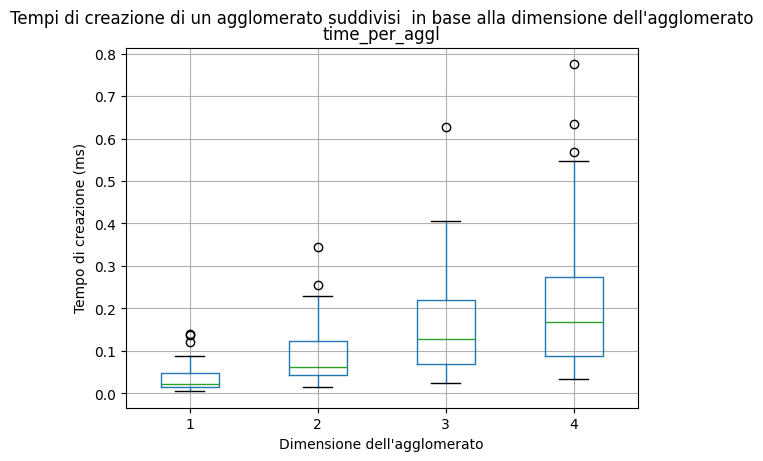

In [153]:
df_gg[["aggl_size", "time_per_aggl"]].boxplot(by="aggl_size")
plt.suptitle("Tempi di creazione di un agglomerato suddivisi  in base alla dimensione dell'agglomerato")
plt.xlabel("Dimensione dell'agglomerato")
plt.ylabel("Tempo di creazione (ms)")

## Reach Goal
L'algoritmo proposto nel Compito 2, chiamato ReachGoal, è progettato per risolvere il problema PF4EA e trova un percorso di costo minimo per un nuovo agente in una griglia con ostacoli e agenti preesistenti.

Come input l'algoritmo riceve:
- le liste di adiacenza dei nodi
- i percorsi degli agenti pre-esistenti
- il nodo iniziale ("Start") e quello finale ("End")
- limite della lunghezza del percorso (t<sub>max</sub>)

In questo algoritmo, l'utilizzo della struttura dati denominata "stato del nodo" (o NodeState) riveste un ruolo cruciale. Questa struttura è composta da quattro campi principali:
- **node**: un intero che rappresenta l'indice del nodo
- **time**: un intero che indica l'istante temporale associato allo stato
- **parent**: il riferimento allo stato genitore, necessario in un secondo momento per ricostruire il percorso
- **weight**: un float che rappresenta il costo complessivo per raggiunger il nodo partendo dal nodo "Start" in tempo "time" 

L'algoritmo, in teoria, richiederebbe l'inizializzazione di tutti gli stati per ogni nodo e per ogni istante temporale da 1 a tmax, impostando il campo parent come vuoto e il campo weight come infinito. Tuttavia, nell'implementazione proposta, questa fase è stata omessa per evitare un uso inefficiente della memoria con dati che, nella maggior parte dei casi, rimarrebbero inutilizzati. In alternativa, gli stati vengono creati dinamicamente durante l'esecuzione, solo nel momento in cui risultano effettivamente necessari. 

L'algoritmo fa uso di altre due strutture dati fondamentali: **Open** e **Closed**, ognuna con un ruolo specifico nell'esecuzione.\
La struttura Open contiene tutti gli stati che devono ancora essere esplorati. A ogni stato in questa struttura è associato un valore chiamato *f-score*, calcolato come `f-score=w+h(stato,end)`. 
Qui, *w* rappresenta il costo del percorso accumulato fino al nodo *n*, mentre `h(stato,end)` è una funzione che stima la distanza tra il nodo corrente *n* e il nodo di destinazione *end*, utilizzando metriche che verranno discusse in dettaglio successivamente.
All'inizio, Open contiene solo lo stato iniziale, corrispondente al nodo di partenza.
Nell'implementazione, Open è stato realizzato come una coda di priorità (o heap) per sfruttare le sue proprietà di efficienza: l'estrazione dello stato con il f-score minimo avviene in tempo O(log⁡n) così come l'inserimento di un nuovo stato. 

La struttura Closed, invece, è l'insieme di tutti gli stati che sono stati già analizzati durante l'esecuzione dell'algoritmo. 
Il suo scopo principale è evitare di riconsiderare stati già esplorati, garantendo così un comportamento efficiente e prevenendo cicli. Nell'implementazione, Closed è stato programmato come una semplice lista, una scelta sufficiente per mantenere traccia degli stati analizzati senza introdurre ulteriori complessità. 

Nel ciclo principale dell'algoritmo, vengono eseguite una serie di istruzioni fondamentali per il progresso verso la soluzione. 
Per prima cosa, dalla struttura Open si estrae lo stato del nodo (NodeState) con il valore di f-score più basso, che viene poi spostato nella struttura Closed per indicare che è stato analizzato. Si verifica se il nodo corrisponde al nodo di destinazione finale. 
In caso affermativo, l'algoritmo termina il ciclo principale e avvia il processo di ricostruzione del percorso ottimale. \
Se il nodo estratto non è il nodo finale, si procede a calcolare gli stati dei nodi adiacenti.
Per ciascun nodo adiacente, viene generato un nuovo stato con un tempo incrementato di 1 rispetto allo stato corrente, un peso pari alla somma del peso dello stato del nodo estratto e del peso del collegamento tra i nodi, e il genitore impostato come il nodo appena estratto. 
Per ciascuno stato calcolato dei nodi vicini, si verifica innanzitutto che il nodo non sia già presente nella struttura Closed. 
Se il nodo è stato precedentemente analizzato, si passa direttamente alla prossima iterazione senza ulteriori controlli. \
Successivamente, si eseguono verifiche per rilevare eventuali collisioni con gli altri agenti.
In questo contesto, possono presentarsi due scenari distinti.
Nel primo caso, se la lunghezza del percorso dell'agente considerato è maggiore di t+1, significa che l'agente si sta ancora muovendo. 
Si verifica quindi in quale nodo l'agente si troverà al tempo t+1.
Nel secondo caso, se la lunghezza del percorso dell'agente è minore o uguale a t+1, significa che l'agente ha raggiunto la propria destinazione finale ed è fermo. In tal caso, si verifica in quale nodo si trova l'agente nell'ultimo istante del suo percorso. \
Se il nodo considerato risulta libero, si passa a controllare se lo stato corrispondente è già presente nella struttura Open. 
Se lo stato è presente, si confrontano i costi e si aggiorna lo stato del nodo con il minimo tra quello già presente e quello appena calcolato. 
In caso contrario, si calcola l'f-score per lo stato e lo si aggiunge alla struttura Open per ulteriori esplorazioni. 

Per il calcolo di f-score sono state utilizzate queste quattro metriche:
- **chebyshev**: \
 *d=max( |x<sub>i</sub> - x<sub>j</sub>|, |y<sub>i</sub> - y<sub>j</sub>|)*
- **euclidea**: \
 *d=sqrt( (x<sub>i</sub> - x<sub>j</sub>)<sup>2</sup> + (y<sub>i</sub> - y<sub>j</sub>)<sup>2</sup>)*
- **manhattan**: \
*d=|x<sub>i</sub> - x<sub>j</sub>|-|y<sub>i</sub> - y<sub>j</sub>|*
- **chess king**: \
 *dif<sub>min</sub> = min( |x<sub>i</sub> - x<sub>j</sub>|, |y<sub>i</sub> - y<sub>j</sub>|)* \
 *dif<sub>max</sub> = max( |x<sub>i</sub> - x<sub>j</sub>|, |y<sub>i</sub> - y<sub>j</sub>|)* \
 *d = sqrt(2) \* dif<sub>min</sub> + (dif<sub>max</sub> - dif<sub>min</sub>)*

La ricostruzione della soluzione avviene seguendo un processo efficiente che sfrutta una struttura dati chiamata deque (coda a doppia terminazione). 
Questa struttura consente di aggiungere o rimuovere elementi sia all'inizio che alla fine in tempo costante O(1), rendendola particolarmente adatta per costruire il percorso in ordine corretto. \
Il processo inizia dal nodo di destinazione, che viene aggiunto alla deque come primo elemento della soluzione. 
Da lì, si risale iterativamente lungo la catena degli stati genitori, selezionando il nodo genitore di ciascun nodo corrente e inserendolo in testa alla deque.
Questo procedimento continua finché non si raggiunge il nodo di partenza. \
Durante questa fase, se il nodo dello stato genitore coincide con il nodo corrente, significa che l'agente è rimasto fermo in quel nodo. 
In tal caso, si incrementa un contatore specifico per registrare i momenti di attesa (wait). \
Una volta completata la ricostruzione, la deque viene restituita sotto forma di lista ordinata, questa conversione, anch'essa eseguita in tempo O(1).

### Analisi dei risultati

In [154]:
df_load_rg = pd.read_csv("./data/result.csv", sep=";")
df_load_rg.head()
df_rg = df_load_rg.iloc[:,0:-1]
map_name_col = {
    "Lenght_solution" : "Solution",
    "Weight_solution" : "Weight",
    "Execution_time(ms)" : "Time_exe",
    "Reconstruct_time(ms)" : "Time_rec",
    "Lenght_close" : "Close",
    "Lenght_open" : "Open"
}
df_rg.rename(columns=map_name_col, inplace=True)
df_rg.head()

,Row,Column,Start,End,Max_time,Aggl_ratio,Aggl_size,N_agent,Heuristic,Solution,Weight,Time_exe,Time_rec,Close,Open,Wait
0,10,10,(0x7),(8x5),20,0.1,1,0,d_chess_king,9,8.828427,1.5487,0.0036,15,65,0
1,10,10,(0x7),(8x5),20,0.1,1,0,d_chebyshev,9,8.828427,1.1169,0.0031,23,74,0
2,10,10,(0x7),(8x5),20,0.1,1,0,d_manhattan,9,8.828427,1.2699,0.0034,19,71,0
3,10,10,(0x7),(8x5),20,0.1,1,0,d_euclidean,9,8.828427,0.8951,0.0038,15,65,0
4,10,10,(0x7),(8x5),20,0.1,1,1,d_chess_king,9,8.828427,0.7802,0.0047,15,65,0


Sono stati trovate le soluzioni di tutti i problemi utilizzando tutte le metriche

In [155]:
df_filter = df_rg[df_rg["Solution"]==0]
df_filter.shape[0]

0

In [156]:
heuristic = ["d_chess_king", "d_euclidean", "d_manhattan", "d_chebyshev"]
map_color = {"d_chess_king": "blue", "d_euclidean": "red", "d_manhattan": "black", "d_chebyshev": "green"}
colors = df_rg["Heuristic"].map(map_color)

In [157]:
def scatter_heuristic(df, x_col, y_col,scale="", x_scale="linear", y_scale="linear", figsize=(14,8), title="", x_label="", y_label=""):
    if x_label == "":
        x_label=x_col
    if y_label == "":
        y_label = y_col
    figure = plt.figure(figsize=figsize)
    gs = GridSpec(1,2, figure=figure, wspace=0.4)
    ax_left =figure.add_subplot(gs[0,0])
    gs_heuristic = gs[0,1].subgridspec(4,1)
    for i in range(0,len(heuristic)):
        heu = heuristic[i]
        df_heu = df[df["Heuristic"] == heu]
        ax = figure.add_subplot(gs_heuristic[i])
        ax.scatter(df_heu[x_col], df_heu[y_col], c=map_color[heu], s=8)
        ax.grid(True)
        if scale!="":
            ax.set_yscale(scale)
            ax.set_xscale(scale)
        else:
            ax.set_yscale(y_scale)
            ax.set_xscale(x_scale)
        ax.set_title(heu)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax_left.scatter(df_heu[x_col], df_heu[y_col], c=map_color[heu], s=8)
    ax_left.grid(True)
    ax_left.legend(map_color)
    ax_left.set_xlabel(x_label)
    ax_left.set_ylabel(y_label)
    if scale!="":
        ax_left.set_xscale(scale)
        ax_left.set_yscale(scale)
    else:
        ax_left.set_yscale(y_scale)
        ax_left.set_xscale(x_scale)
    figure.subplots_adjust(hspace=1)
    plt.suptitle(title)

In [158]:
def plot_multiple_scatter(df, x_col, y_col):
    fig, axis = plt.subplots(nrows=2,ncols=2, figsize=(10,8))
    min = df[x_col].min()
    max = df[x_col].max()
    delta = ( max - min ) / 4
    df_sub = df[df[x_col] <= min + delta]
    axis[0][0].scatter(df_sub[x_col], df_sub[y_col])
    df_sub = df[(df[x_col] > min + delta) & (df[x_col] <= min + 2*delta)]
    axis[0][1].scatter(df_sub[x_col], df_sub[y_col])
    df_sub = df[(df[x_col] > min + 2*delta) & (df[x_col] <= max - delta)]
    axis[1][0].scatter(df_sub[x_col], df_sub[y_col])
    df_sub = df[(df[x_col] > max -delta) & (df[x_col] <= max)]
    axis[1][1].scatter(df_sub[x_col], df_sub[y_col])


#### Tempo esecuzione
Come mostrano i grafici seguenti, i tempi seguono un andamento dell'algoritmo di tipo esponenziale. Si osservano anche notevoli differenze nei risultati in base alla metrica utilizzata. In particolare, la distanza di Chebyshev mostra una performance significativamente inferiore, arrivando a essere fino a dieci volte peggiore rispetto ad altre metriche. La distanza Manhattan, invece, si distingue per le prestazioni migliori, seguita dalla distanza "chess king" che si posiziona subito dopo in termini di efficienza.

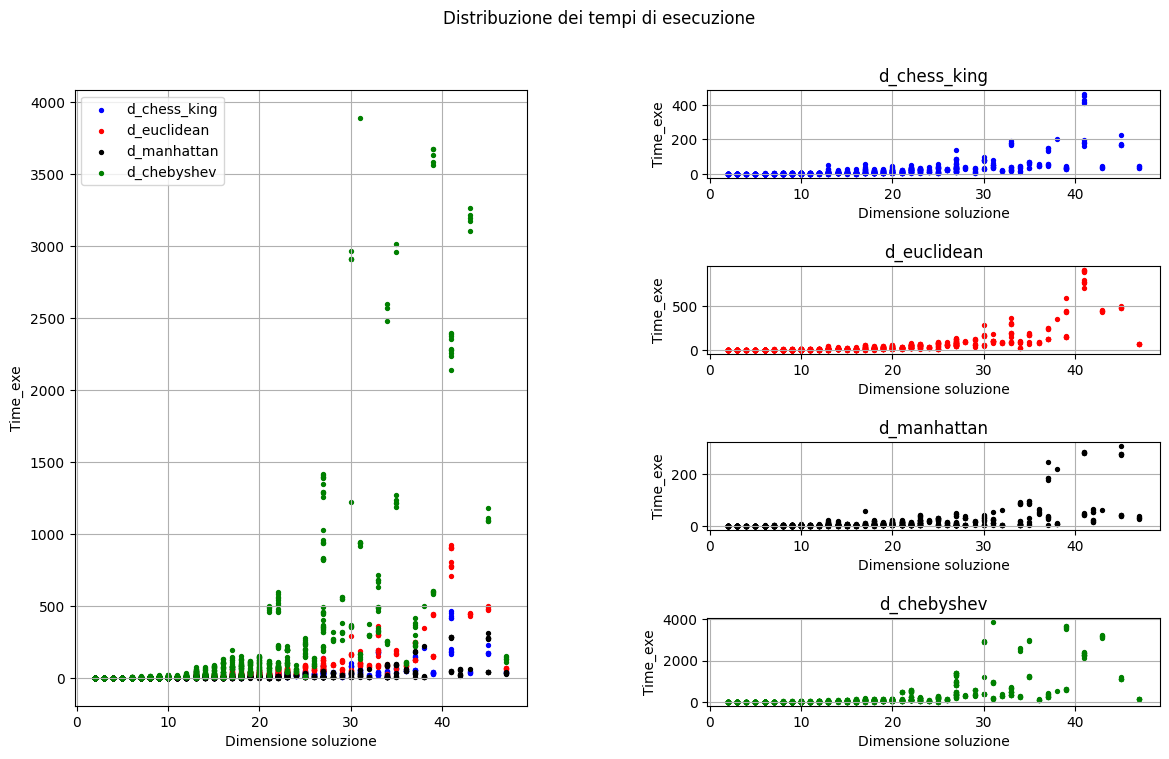

In [159]:
scatter_heuristic(df_rg,"Solution", "Time_exe", title="Distribuzione dei tempi di esecuzione", x_label="Dimensione soluzione")

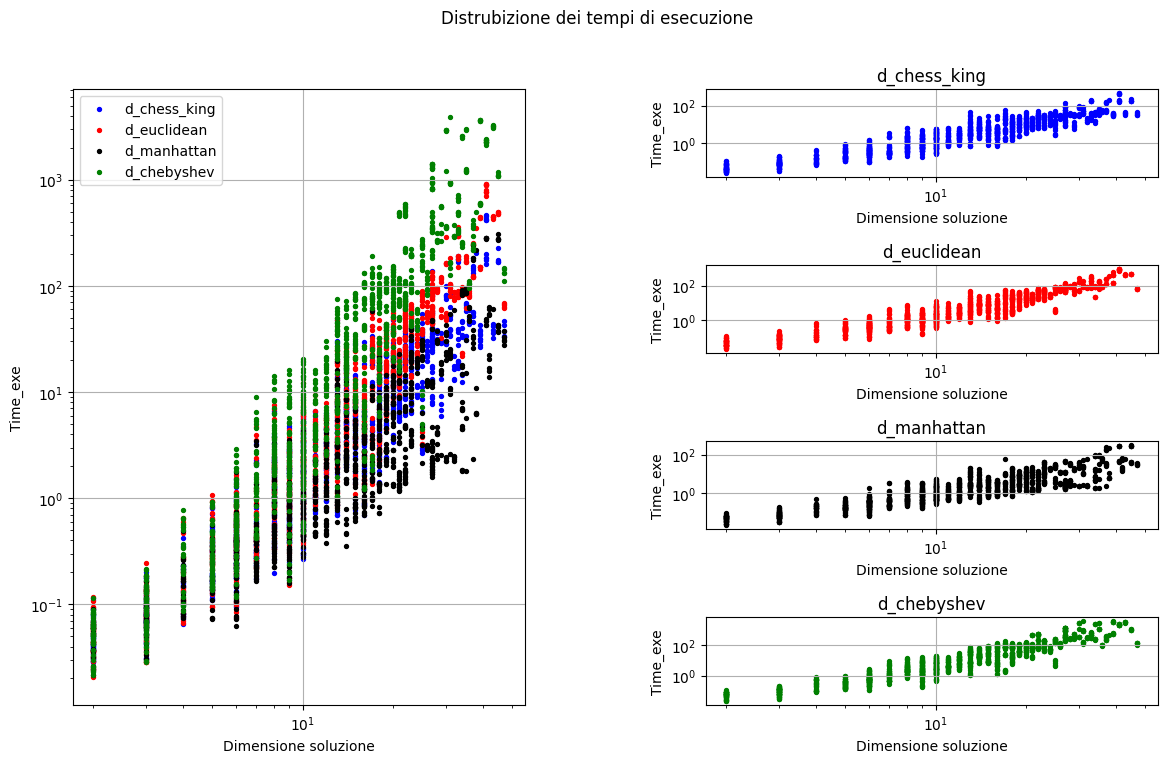

In [160]:
scatter_heuristic(df_rg,"Solution", "Time_exe", scale="log", title="Distrubizione dei tempi di esecuzione",x_label="Dimensione soluzione")

#### Close
Anche per quanto riguarda la dimensione dell'insieme Closed, l'occupazione della memoria segue un andamento esponenziale. Come nel caso dell'analisi dei tempi, anche in questo caso le metriche Manhattan e "chess king" mostrano prestazioni migliori, mentre la metrica di Chebyshev risulta significativamente più lenta. La presenza di numerosi elementi nell'insieme Closed indica che un gran numero di nodi è stato espanso durante l'esecuzione, il che spiega le differenze nelle performance osservate.

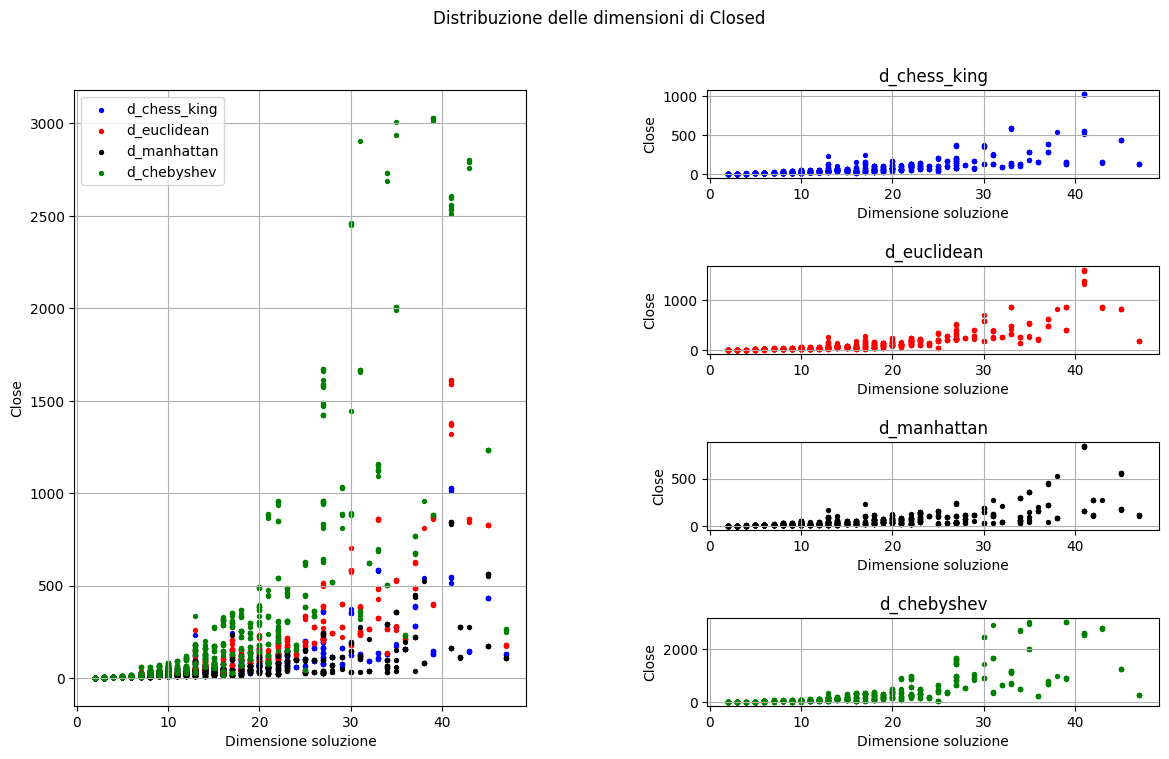

In [161]:
scatter_heuristic(df_rg, "Solution", "Close", title="Distribuzione delle dimensioni di Closed", x_label="Dimensione soluzione")

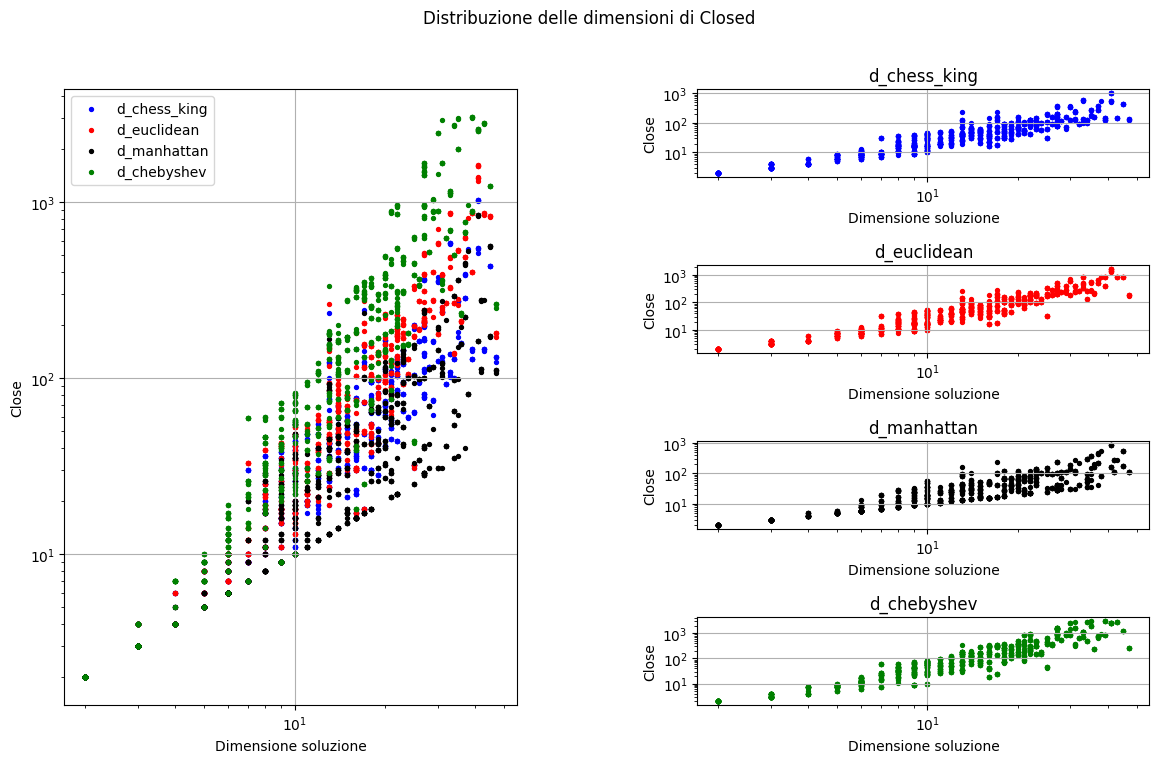

In [162]:
scatter_heuristic(df_rg, "Solution", "Close", scale="log", title="Distribuzione delle dimensioni di Closed", x_label="Dimensione soluzione")

#### Open
Anche per la dimensione di Open, le prestazioni seguono lo stesso andamento osservato nei due casi precedenti. Questo evidenzia come l'algoritmo sia altamente influenzato dalla metrica utilizzata. La scelta di una metrica adeguata permette di ottenere tempi di esecuzione significativamente più rapidi, nonostante la crescita esponenziale che caratterizza il processo.

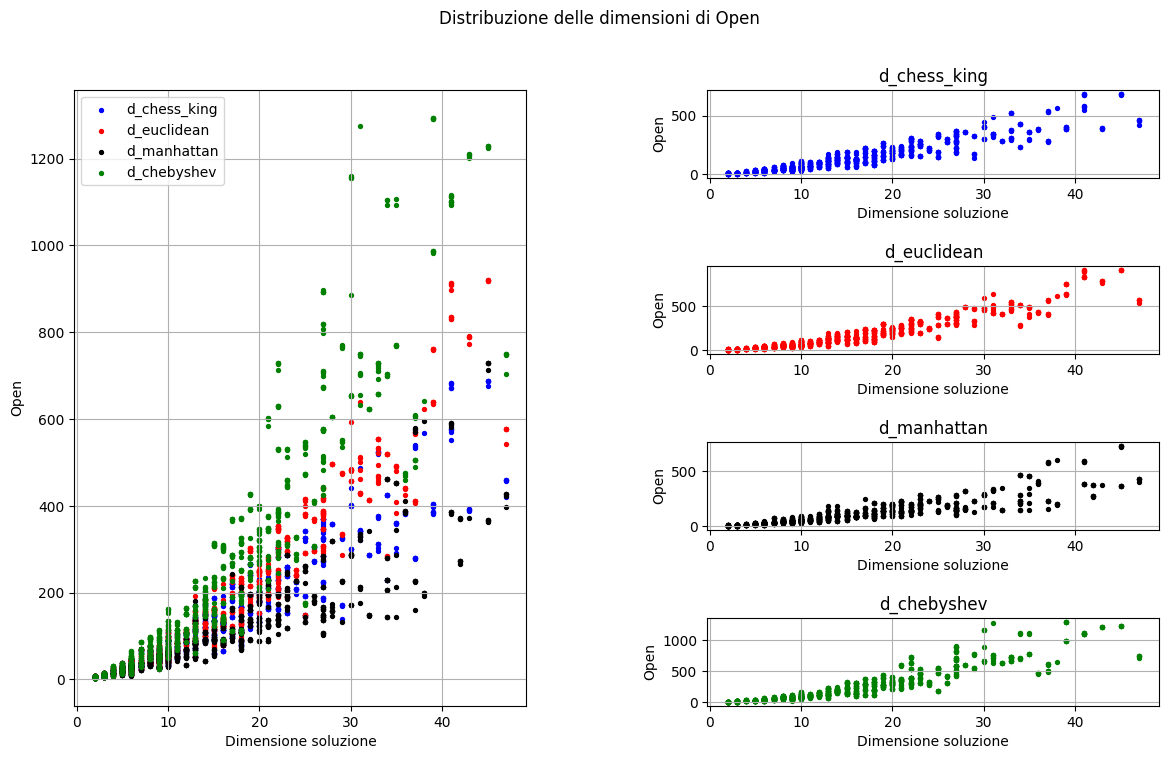

In [163]:
scatter_heuristic(df_rg, "Solution", "Open", title="Distribuzione delle dimensioni di Open", x_label="Dimensione soluzione")

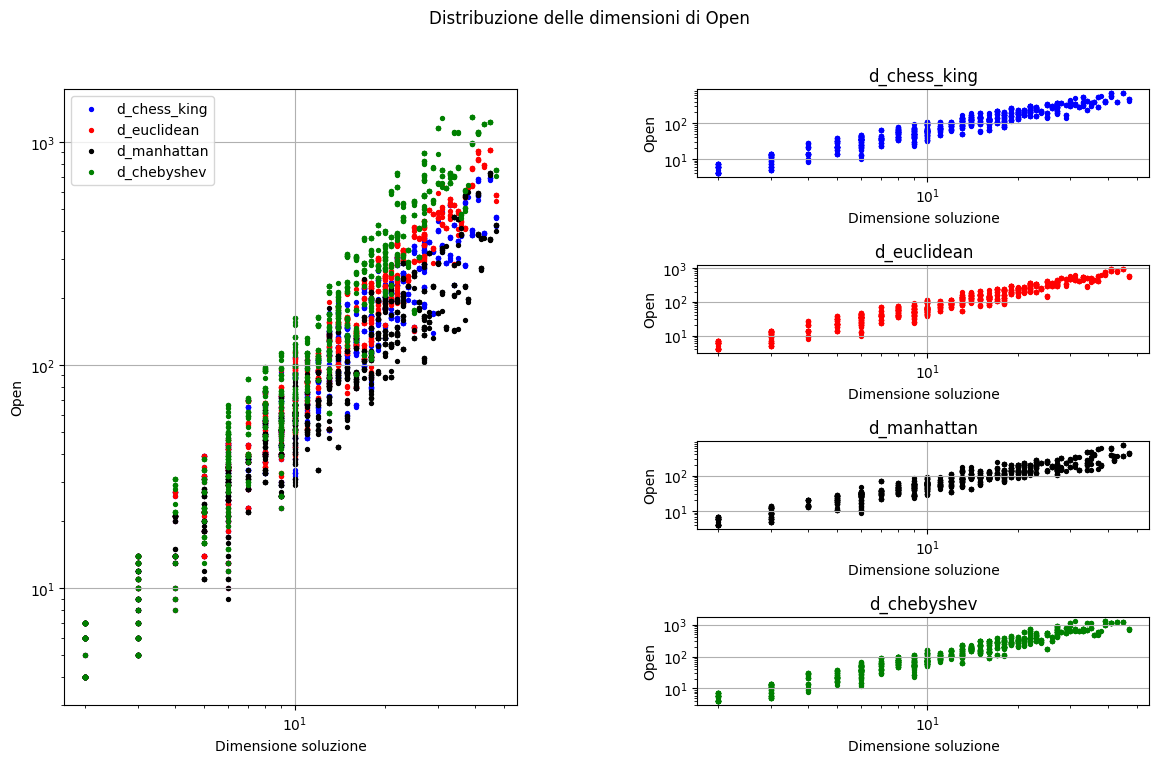

In [164]:
scatter_heuristic(df_rg, "Solution", "Open", scale="log", title="Distribuzione delle dimensioni di Open", x_label="Dimensione soluzione")

#### Tempo di ricostruzione
La fase di ricostruzione della soluzione presenta un andamento lineare, come dimostrato dall'analisi dei tempi. A conferma di ciò, il rapporto tra il tempo impiegato e la lunghezza della soluzione si mantiene sostanzialmente costante, con una leggera tendenza a diminuire all'aumentare della lunghezza.

Inoltre, in questa fase, non si osservano differenze significative dovute alla metrica utilizzata, a conferma che l'impatto delle metriche è circoscritto alle fasi precedenti dell'algoritmo.

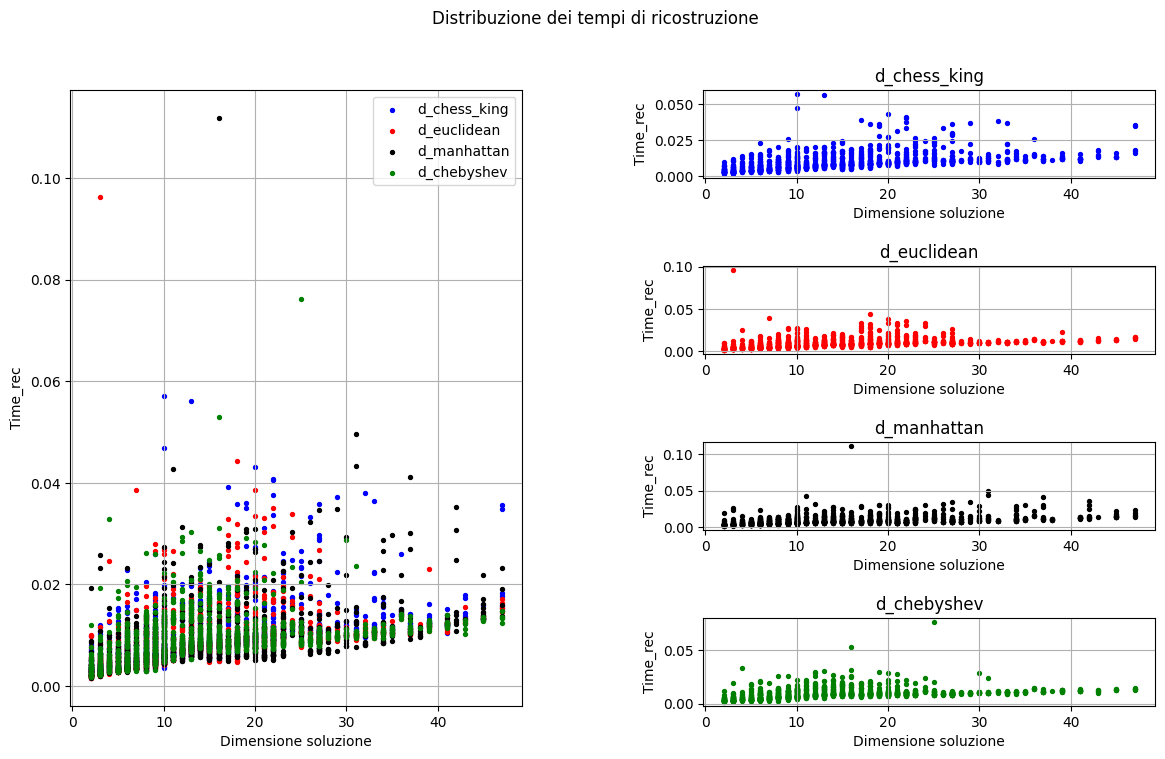

In [165]:
scatter_heuristic(df_rg, "Solution", "Time_rec", title="Distribuzione dei tempi di ricostruzione", x_label="Dimensione soluzione")


Text(0.5, 0, 'Dimensione soluzione')

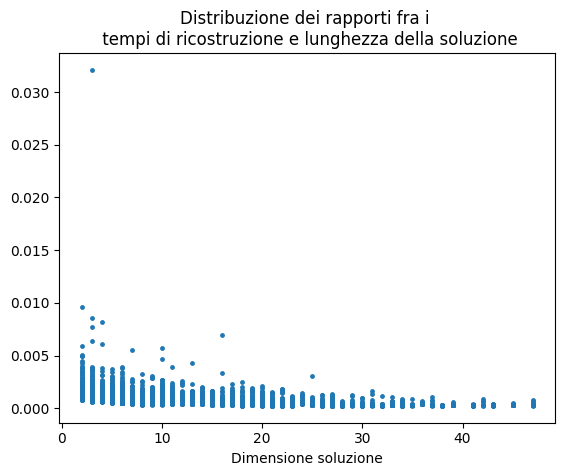

In [166]:
df_rg["Time_rec_by_sol"] = df_rg["Time_rec"] / df_rg["Solution"]
plt.scatter(df_rg["Solution"], df_rg["Time_rec_by_sol"], s=6)
plt.title("Distribuzione dei rapporti fra i \n tempi di ricostruzione e lunghezza della soluzione")
plt.xlabel("Dimensione soluzione")